In [1]:
import concrete.numpy as cnp

In [2]:
def add(x, y):
    return x + y


In [3]:
compiler = cnp.Compiler(add, {"x": "encrypted", "y":"clear"})

inputset = [(2, 3), (0, 0), (1, 6), (7,7), (7, 1), (13, 16), (102, 50), (454, 2332)]

circuit = compiler.compile(inputset)

x = 4
y = 4

for t in inputset:
        res_clear = add(t[0], t[1])
        res_hm = circuit.encrypt_run_decrypt(t[0], t[1])
        print(x, "+", y, "=", res_clear, "=", res_hm)

4 + 4 = 5 = 5
4 + 4 = 0 = 0
4 + 4 = 7 = 7
4 + 4 = 14 = 14
4 + 4 = 8 = 8
4 + 4 = 29 = 29
4 + 4 = 152 = 152
4 + 4 = 2786 = 2786


In [4]:
x = 102
y = 500
res_clear = add(x, y)
res_hm = circuit.encrypt_run_decrypt(x, y)
print(res_clear)
print(res_hm)

602
602


In [5]:
@cnp.compiler({"x": "encrypted"})
def f(x):
    return x ** 2

inputset = range(2 ** 4)
circuit = f.compile(inputset)

In [ ]:
"""import time

import numpy as np

WARMUP = 3
SAMPLES = 8
BITWIDTHS = range(1, 15)
CONFIGURATION = cnp.Configuration(
    enable_unsafe_features=True,
    use_insecure_key_cache=True,
    insecure_key_cache_location=".keys",
)

timings = {}
for n in BITWIDTHS:
    @cnp.compiler({"x": "encrypted"})
    def base(x):
        return x

    table = cnp.LookupTable([np.sqrt(x).round().astype(np.int64) for x in range(2 ** n)])

    @cnp.compiler({"x": "encrypted"})
    def tlu(x):
        return table[x]

    inputset = [0, 2**n - 1]

    base_circuit = base.compile(inputset, CONFIGURATION)
    tlu_circuit = tlu.compile(inputset, CONFIGURATION)

    print()
    print(f"Generating keys for n={n}...")

    base_circuit.keygen()
    tlu_circuit.keygen()

    timings[n] = []
    for i in range(SAMPLES + WARMUP):
        sample = np.random.randint(0, 2 ** n)

        encrypted_sample = base_circuit.encrypt(sample)
        start = time.time()
        encrypted_result = base_circuit.run(encrypted_sample)
        end = time.time()
        assert base_circuit.decrypt(encrypted_result) == sample

        base_time = end - start

        encrypted_sample = tlu_circuit.encrypt(sample)
        start = time.time()
        encrypted_result = tlu_circuit.run(encrypted_sample)
        end = time.time()
        assert tlu_circuit.decrypt(encrypted_result) == np.sqrt(sample).round().astype(np.int64)

        tlu_time = end - start

        if i >= WARMUP:
            timings[n].append(tlu_time - base_time)
            print(f"Sample #{i - WARMUP + 1} took {timings[n][-1] * 1000:.3f}ms")

print()
for n, times in timings.items():
    print(f"{n}-bits -> {np.mean(times) * 1000:.3f}ms")"""

In [7]:
str(circuit)

'%0 = x                    # EncryptedScalar<uint4>        ∈ [0, 15]\n%1 = 2                    # ClearScalar<uint2>            ∈ [2, 2]\n%2 = power(%0, %1)        # EncryptedScalar<uint8>        ∈ [0, 225]\nreturn %2'

In [26]:
import numpy as np


#@cnp.compiler({"z":"encrypted"})
def g(z):
    with cnp.tag("function g"):
        a = 120 - z
        b = a // 4
    return b

@cnp.compiler({"x":"encrypted"})
def f(x):
    with cnp.tag("abc"):
        x = x * 2
        with cnp.tag("foo"):
            y = x + 7
        z = np.sqrt(y).astype(np.int64)
    return g(z+3) * 2


inputset = range(10)

circuit = f.compile(inputset)
print(circuit)

 %0 = x                            # EncryptedScalar<uint4>        ∈ [0, 9]
 %1 = 2                            # ClearScalar<uint2>            ∈ [2, 2]            @ abc
 %2 = multiply(%0, %1)             # EncryptedScalar<uint5>        ∈ [0, 18]           @ abc
 %3 = 7                            # ClearScalar<uint3>            ∈ [7, 7]            @ abc.foo
 %4 = add(%2, %3)                  # EncryptedScalar<uint5>        ∈ [7, 25]           @ abc.foo
 %5 = subgraph(%4)                 # EncryptedScalar<uint3>        ∈ [2, 5]            @ abc
 %6 = 3                            # ClearScalar<uint2>            ∈ [3, 3]
 %7 = add(%5, %6)                  # EncryptedScalar<uint4>        ∈ [5, 8]
 %8 = 120                          # ClearScalar<uint7>            ∈ [120, 120]        @ function g
 %9 = subtract(%8, %7)             # EncryptedScalar<uint7>        ∈ [112, 115]        @ function g
%10 = 4                            # ClearScalar<uint3>            ∈ [4, 4]            @ function g

In [31]:
def complex_univariate_fn(x):
    def per_element(ele):
        res = 0
        for i in range(ele):
            res += i
        return res
    return np.vectorize(per_element)(x)


@cnp.compiler({"x":"encrypted"})
def f(x):
    return cnp.univariate(complex_univariate_fn)(x)

sample = np.array([[0, 4], [2, 1], [3, 0]])
res_clr = complex_univariate_fn(sample)
print(res_clr)

[[0 6]
 [1 0]
 [3 0]]


In [32]:
inputset = [np.random.randint(0, 5, size=(3, 2)) for _ in range(10)]
circuit = f.compile(inputset)
res_hm = circuit.encrypt_run_decrypt(sample)
print(res_hm)

[[0 6]
 [1 0]
 [3 0]]


In [34]:
table = cnp.LookupTable([2, -1, 3, 0])

@cnp.compiler({"x": "encrypted"})
def f(x):
    return table[x]

inputset = range(4)
circuit = f.compile(inputset)

assert circuit.encrypt_run_decrypt(0) == table[0] == 2
assert circuit.encrypt_run_decrypt(1) == table[1] == -1
assert circuit.encrypt_run_decrypt(2) == table[2] == 3
assert circuit.encrypt_run_decrypt(3) == table[3] == 0

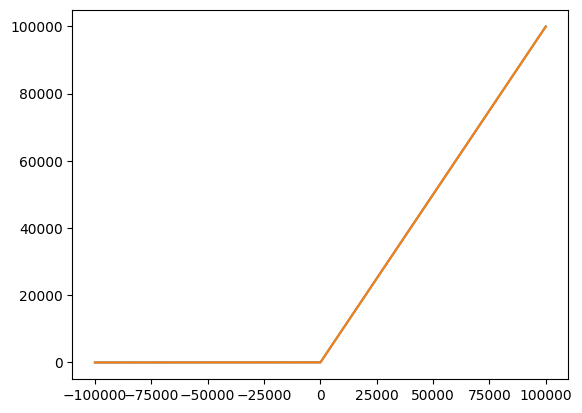

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

def relu(x):
    return x if x >= 0 else 0

xs = range(-100_000, 100_000)
ys = [relu(x) for x in xs]

plt.plot(xs, ys)
plt.show()

In [53]:
@cnp.compiler({"x": "encrypted"})
def f(x):
    return np.sqrt(x * 100_000).round().astype(np.int64)

inputset = range(100_000, 101_000)
circuit = f.compile(inputset, enable_unsafe_features=True, virtual=True)

print(circuit)
print(circuit.encrypt_run_decrypt(100_500), "~=", np.sqrt(100_500 * 100_000))

%0 = x                       # EncryptedScalar<uint17>        ∈ [100000, 100999]
%1 = 100000                  # ClearScalar<uint17>            ∈ [100000, 100000]
%2 = multiply(%0, %1)        # EncryptedScalar<uint34>        ∈ [10000000000, 10099900000]
%3 = subgraph(%2)            # EncryptedScalar<uint17>        ∈ [100000, 100498]
return %3

Subgraphs:

    %3 = subgraph(%2):

        %0 = input                         # EncryptedScalar<uint1>
        %1 = sqrt(%0)                      # EncryptedScalar<float64>
        %2 = around(%1, decimals=0)        # EncryptedScalar<float64>
        %3 = astype(%2, dtype=int_)        # EncryptedScalar<uint1>
        return %3


RuntimeError: Virtual circuits cannot use `encrypt` method